<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT21/blob/YinengWang/Lab_6/Lab6_YinengWang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 6: Differential Equations**
**Yineng Wang**

# **Abstract**

This report includes the implementation and test for

1. Time stepping for scalar initial value problem du/dt = f(u,t)
2. Time stepping for a system of  initial value problems du/dt = f(u,t)
3. Simulate a trajectory of a stochastic differential equation dX\_t = mu\*X\_t\*dt + sigma\*X\_t\*dW

#**About the code**

This report is written by Yineng Wang, based on Johan Hoffman's template.

In [1]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [2]:
import unittest

import numpy as np
from matplotlib import pyplot as plt

# **Introduction**

The basic idea of time stepping methods to solve the initial value problem
$$
\dot u(t) = f(u(t), t), \quad u(0) = u_0
$$
is to compute successive approximations $U(t_n)$ of $u$ on a partition
$$0 = t_0 < t_1 < \dots < t_N = T.$$

$U(t_n)$ can be estimated explicitly by computing the value of a function of $U(t_{n-1})$ and $t_{n-1}$, or can be estimated implicitly by solving an equation of $U(t_n)$. The method can be generalized to systems of IVPs.

# **Method**

## 1. Time stepping for scalar initial value problem du/dt = f(u,t)

Input: final time T, function f(u,t), initial value u(0)

Output: approximation U(t_n) for the time interval [0,T]

We implement our time stepping method, the $\theta$-method, whose iteration takes form of
$$
U(t_n) = U(t_{n-1}) + k_n ((1-\theta) f(U({t_n}), t_n) + \theta f(U(t_{n-1}), t_{n-1})).
$$
The method is explicit if $\theta = 1$, and otherwise implicit.

The method is described in algorithm (13.3) in the lecture notes. To solve the equation, the Newton's method implemented in Lab 2 is introduced.

In [3]:
def derivative(f, x, h):
    return (f(x + h/2) - f(x - h/2)) / h


def newton_method(f, tol=1e-6, max_iter=200, x0=0, h=1e-3):
    x = x0
    n_iter = 0
    while True:
        f_x = f(x)
        if abs(f_x) < tol:
            return x
        x -= f_x / derivative(f, x, h)
        n_iter += 1
        if n_iter > max_iter:
            raise ValueError('the iteration diverges')


def scalar_ivp(T, f, u0, N=100, theta=0.5):
    t = np.linspace(0, T, N)
    sol = np.zeros(N)
    sol[0] = u0
    k = T / N
    for step in range(1, N):
        sol[step] = newton_method(
            lambda x: x - sol[step-1] - k * ((1-theta) * f(x, t[step]) + theta * f(sol[step-1], t[step-1])),
            x0=sol[step-1]
        )
    return sol

## 2. Time stepping for a system of initial value problems du/dt = f(u,t)

Input: final time T, function f(u,t), initial value u(0)

Output: approximation U(t_n) for the time interval [0,T]

We also use the $\theta$-method to solve the system of intial value problems. The $\theta$-method for a system of IVP involves solving a system of non-linear equations. Therefore, the Newton's method for multivariable functions implemented in Lab 2 is introduced.

The return value of this function is a $M \times N$ matrix, where $M$ is the number of equations in the IVP, and $N$ is the number of time steps.

In [4]:
def jacobian(f, x, m, n, h):
    J = np.zeros((m, n))
    for j in range(n):
        dx = np.zeros(n)
        dx[j] = h/2
        Df = (f(x+dx) - f(x-dx)) / h
        J[:,j] = Df
    return J


def newton_method_vector(f, x0, tol=1e-6, max_iter=200, h=1e-3):
    x = x0.copy()
    n_iter = 0
    while True:
        f_x = f(x)
        if np.linalg.norm(f_x) < tol:
            return x
        J = jacobian(f, x, f_x.shape[0], x.shape[0], h)
        x -= np.linalg.solve(J, f_x)
        n_iter += 1
        if n_iter > max_iter:
            raise ValueError('the iteration diverges')


def vector_ivp(T, f, u0, N=100, theta=0.5):
    M = len(u0)
    t = np.linspace(0, T, N)
    sol = np.zeros((M, N))
    sol[:,0] = u0
    k = T / N
    for step in range(1, N):
        sol[:,step] = newton_method_vector(
            lambda x: x - sol[:,step-1] - k * ((1-theta) * f(x, t[step]) + theta * f(sol[:,step-1], t[step-1])),
            x0=sol[:,step-1]
        )
    return sol

## 3. Simulate a trajectory of a stochastic differential equation dX\_t = mu\*X\_t\*dt + sigma\*X\_t\*dW

Input: final time T, drift mu, volatility sigma,  initial value vector X_0

Output: approximation vector X_t for the time interval [0,T]

We use the Euler-Maruyama method to get a trajectory of the SDE:

$$
x_n = x_{n-1} + \mu(x_{n-1}, t_{n-1}) \Delta t_n + \sigma(x_{n-1}, t_{n-1}) \Delta W_n,
$$

with the time step size $\Delta t_n = t_n - t_{n-1}$, and the increment of the Wiener process $\Delta W_n = W_{t_n} - W_{t_{n-1}} \sim N(0, \Delta t_n)$.

In [5]:
def sde_trajectory(T, mu, sigma, x0, N=100):
    t = np.linspace(0, T, N)
    sol = np.zeros(N)
    sol[0] = x0
    k = T / N
    sqrt_k = np.sqrt(k)
    for step in range(1, N):
        dW = np.random.normal(0, sqrt_k)
        sol[step] = sol[step-1] + k * mu(sol[step-1], t[step-1]) + dW * sigma(sol[step-1], t[step-1])
    return sol

# **Results**

## 1. Time stepping for scalar initial value problem du/dt = f(u,t)

Test: verify accuracy and stability with respect to model problem.

For the linear model problem
$$
\dot u(t) + \lambda u(t) = g(t), \quad u(0) = u_0,
$$

it is proved in the lecture notes that a equilibrium point $u^* = 0$ is stable if $\lambda > 0$ and unstable if $\lambda < 0$. If $\lambda = 0$, then the equilibrium point with a pertubation $u^* + \epsilon$ is a new equilibrium point.

We use the model problems $\dot u(t) = -\alpha u(t), u(0) = u_0$ to test the accuracy and stability of the time stepping method for scalar IVP. The problem has a closed-form solution $u(t) = u_0 e^{-\alpha t}$. It has an equilibrium point $u^* = 0$. With the initial value $u(0) = u^* = 0$, we analyze the following two IVPs
$$
\dot u(t) = -\alpha u(t), \quad u(0) = 0, \\
\dot v(t) = -\alpha v(t), \quad v(0) = \epsilon.
$$

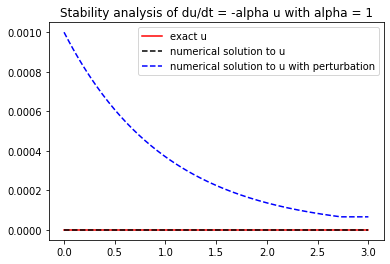

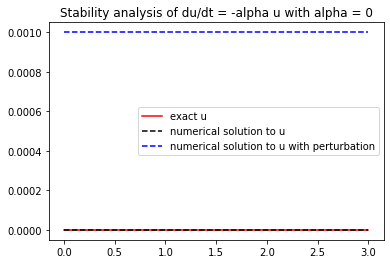

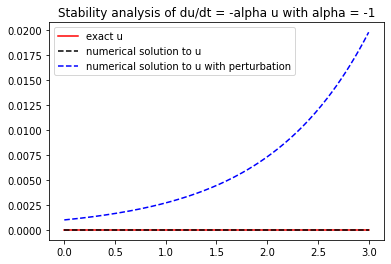

In [42]:
def test_scalar_ivp():
    epsilon = 1e-3
    T = 3
    N = 200
    t = np.linspace(0, T, N)
    # IVP: du/dt = -alpha u, with equilibrium point u* = 0
    for alpha in [1, 0, -1]:
        f = lambda u, t: -alpha*u
        exact = np.repeat(0, N)    # exact solution with u0 = 0
        u = scalar_ivp(T, f, 0, N)
        v = scalar_ivp(T, f, epsilon, N)

        l1, = plt.plot(t, exact, color='red')
        l2, = plt.plot(t, u, '--', color='black')
        l3, = plt.plot(t, v, '--', color='blue')
        plt.legend(handles=[l1,l2,l3], labels=[
            'exact u', 'numerical solution to u',
            'numerical solution to u with perturbation'], loc='best')
        plt.title(f'Stability analysis of du/dt = -alpha u with alpha = {alpha}')
        plt.show()


test_scalar_ivp()

## 2. Time stepping for a system of initial value problems du/dt = f(u,t)

Test: verify accuracy and stability with respect to model problem.

For the linear model problem

$$
\dot u(t) = -A u(t),
$$

according to the lecture notes (section (14.2)), if $A$ has an eigenvalue with a negative real part, the perturbation $\epsilon$ will grow exponentially. If all eigenvalues have positive real parts, the perturbation will decay at exponential rate. For purely imaginary eigenvalues, the perturbation will oscillate around the equilibrium point.

We use $2 \times 2$ matrix $A$, and select the value of $A$ such that

1. $A$ has only positive real eigenvalues,
2. $A$ has one negative real eigenvalue,
3. $A$ has only non-real eigenvalues with positive real part,
4. $A$ has only non-real eigenvalues and one eigenvalue with negative real part,
5. $A$ has only purely imaginary eigenvalues.

With $u(0)$ being the equilibrium point $(0, 0)^T$, the IVP has exact solution $u(t) = (0, 0)^T$.

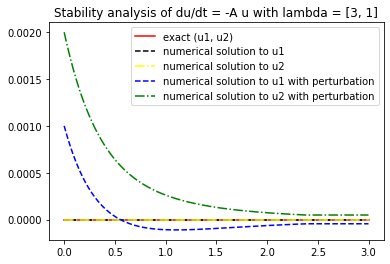

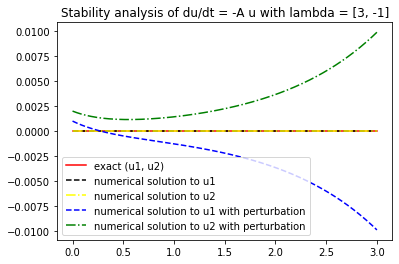

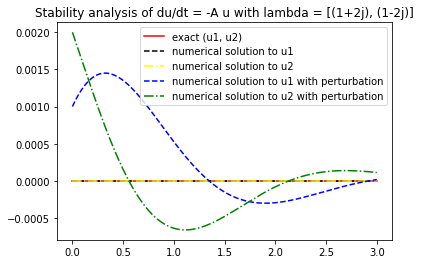

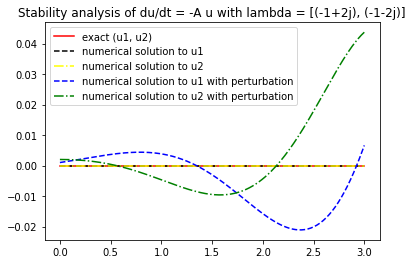

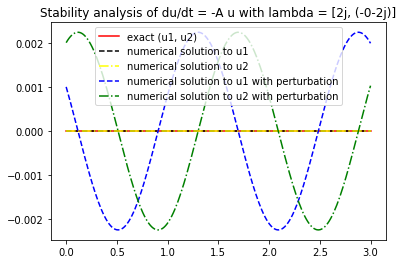

In [51]:
def test_vector_ivp():
    epsilon1 = 1e-3
    epsilon2 = 2e-3
    T = 3
    N = 200
    t = np.linspace(0, T, N)
    # IVP: du/dt = -A u(t), with equilibrium point u* = 0
    A1, lambda1 = np.array([[2, 1], [1, 2]]), [3, 1]
    A2, lambda2 = np.array([[1, 2], [2, 1]]), [3, -1]
    A3, lambda3 = np.array([[1, -2], [2, 1]]), [1+2j, 1-2j]
    A4, lambda4 = np.array([[-1, -2], [2, -1]]), [-1+2j, -1-2j]
    A5, lambda5 = np.array([[0, 4], [-4, 0]]), [2j, -2j]
    for A, lambda_ in zip([A1, A2, A3, A4, A5], [lambda1, lambda2, lambda3, lambda4, lambda5]):
        f = lambda u, t: -A@u
        exact = np.repeat(0, N)    # exact solution with u0 = 0
        u = vector_ivp(T, f, np.array([0, 0]), N)
        v = vector_ivp(T, f, np.array([epsilon1, epsilon2]), N)

        l1, = plt.plot(t, exact, color='red')
        l21, = plt.plot(t, u[0,:], '--', color='black')
        l22, = plt.plot(t, u[1,:], '-.', color='yellow')
        l31, = plt.plot(t, v[0,:], '--', color='blue')
        l32, = plt.plot(t, v[1,:], '-.', color='green')
        plt.legend(handles=[l1,l21,l22,l31,l32], labels=[
            'exact (u1, u2)', 'numerical solution to u1', 'numerical solution to u2',
            'numerical solution to u1 with perturbation',
            'numerical solution to u2 with perturbation'], loc='best')
        plt.title(f'Stability analysis of du/dt = -A u with lambda = {lambda_}')
        plt.show()

test_vector_ivp()

## 3. Simulate a trajectory of a stochastic differential equation dX\_t = mu\*X\_t\*dt + sigma\*X\_t\*dW

Test: simulate a number of trajectories and verify that E[X_t] = X_0\*exp(mu\*t).

We select a group of constants for $\mu$, $\sigma$ and $x_0$. The expection of $X_t$ is estimated by simulating multiple trajectories and computing the average of $X_t$ of this trajectories.

mu = 0, sigma = 1, x0 = 1, x0 * exp(mu*t) = 1.0, computed average = 1.0907666843491055


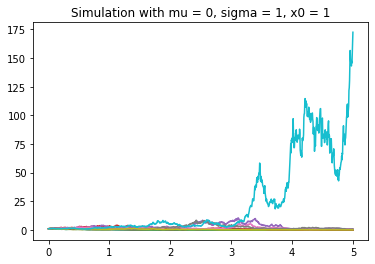

mu = 1, sigma = 0.5, x0 = -1, x0 * exp(mu*t) = -148.4131591025766, computed average = -147.8144672935406


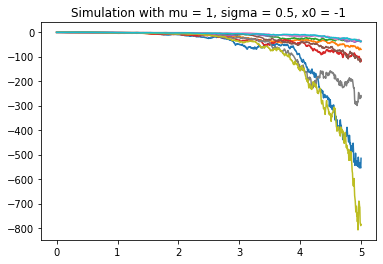

mu = -1, sigma = 2, x0 = 10, x0 * exp(mu*t) = 0.06737946999085467, computed average = 0.010954151709845662


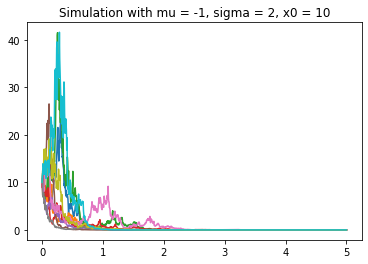

In [70]:
def test_sde_trajectory(num_sims=2000, num_curves=10):
    T = 5
    N = 1000
    t = np.linspace(0, T, N)
    for mu, sigma, x0 in [(0, 1, 1), (1, 0.5, -1), (-1, 2, 10)]:
        mu_func = lambda x, t: mu * x
        sigma_func = lambda x, t: sigma * x
        xt = 0
        for sim in range(num_sims):
            x = sde_trajectory(T, mu_func, sigma_func, x0, N)
            xt += x[-1]
            if sim < num_curves:
                plt.plot(t, x)
        xt /= num_sims
        print(f'mu = {mu}, sigma = {sigma}, x0 = {x0}, x0 * exp(mu*t) = {x0 * np.exp(mu*T)}, computed average = {xt}')
        plt.title(f'Simulation with mu = {mu}, sigma = {sigma}, x0 = {x0}')
        plt.show()

test_sde_trajectory()

# **Discussion**

As the graph shows, for scalar model IVPs, a equilibrium point $u^* = 0$ is stable (the perturbation will decay) if $\lambda > 0$ and unstable (the perturbation will grow) if $\lambda < 0$. If $\lambda = 0$, then the equilibrium point with a pertubation $u^* + \epsilon$ is a new equilibrium point (the perturbation is perserved).

For vector model IVPs, the perturbation decays if the real part of all eigenvalues are positive; it grows if an eigenvalue has negative real part. The imaginary part causes the perturbation to oscillate.

According to the result of the simulation of SDE, we know that the absolute error between the theoretical value and the result of simulation can be as large as 0.6, if we conduct 2,000 simulations.